In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Successfully loaded data from Google Drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 69s 29ms/step - accuracy: 0.4021 - loss: 1.1701 - val_accuracy: 0.0327 - val_loss: 1.6593 - learning_rate: 5.0000e-04
Epoch 2/200
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 85s 31ms/step - accuracy: 0.4388 - loss: 1.0247 - val_accuracy: 0.0453 - val_loss: 1.6395 - learning_rate: 5.0000e-04
Epoch 3/200
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - accuracy: 0.4485 - loss: 1.0141 - val_accuracy: 0.0512 - val_loss: 1.6356 - learning_rate: 5.0000e-04
Epoch 4/200
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 65s 29ms/step - accuracy: 0.4501 - loss: 1.0077 - val_accuracy: 0.1114 - val_loss: 1.5874 - learning_rate: 5.0000e-04
Epoch 5/200
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.4592 - loss: 0.9979 - val_accuracy: 0.1785 - val_loss: 1.5475 - learning_rate: 5.0000e-04
Epoch 6/200
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.4657 - loss: 0.9890 - val_accuracy: 0.2544 - val_loss: 1.4923 - learning_rate: 5.0000e-04
Epoch 7/200
2231/2231 ━━━━━━━━━━━━

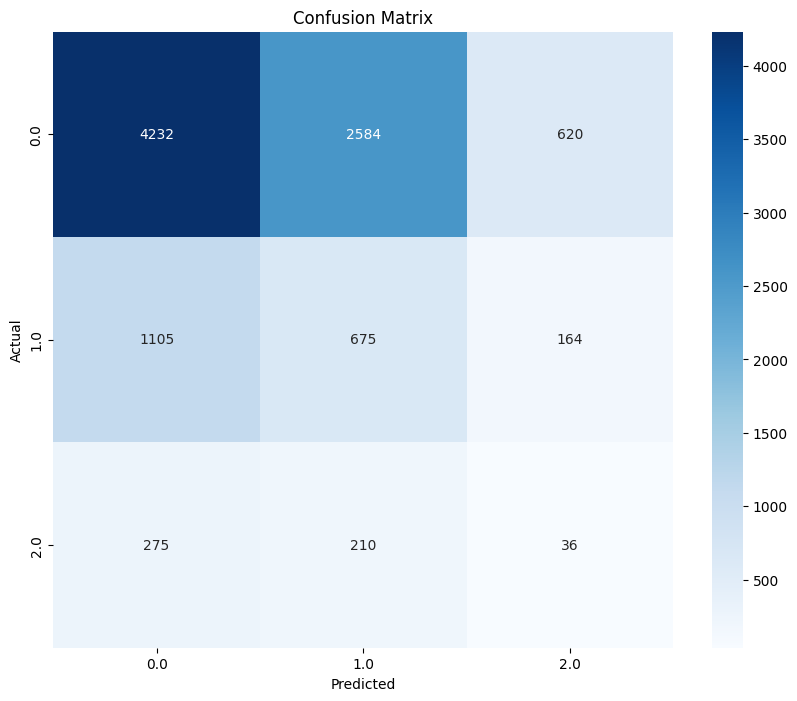

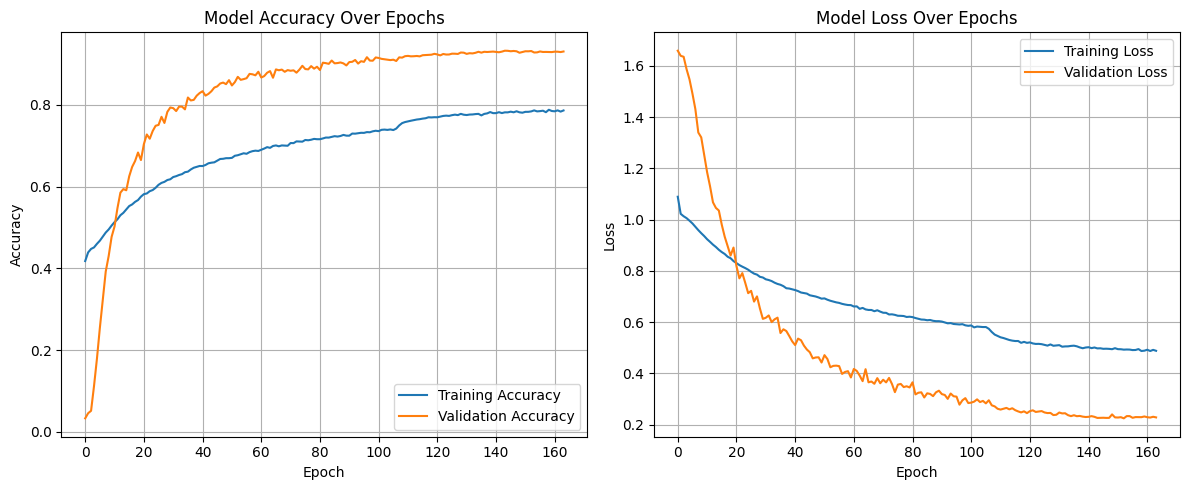

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

# Load data
try:
    cleaned_dataset_path = '/content/drive/My Drive/ML/new.csv'
    data = pd.read_csv(cleaned_dataset_path)
    print("Successfully loaded data from Google Drive")
except:
    try:
        data = pd.read_csv('new.csv')
        print("Successfully loaded data from local directory")
    except:
        print("Error: Could not load the dataset.")
        raise

# Define features and target
features = [
    'Heart_Rate', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
    'Skin_Temperature', 'Respiration_Rate', 'Sleep_Duration',
    'Activity_Levels', 'Mood', 'Stress_Level', 'Resilience_Factors'
]
target = 'Mental_Health_Status'

# Add engineered features
data['HR_BP_Ratio'] = data['Heart_Rate'] / (data['Blood_Pressure_Systolic'] + 1e-8)
data['Sleep_Stress_Score'] = data['Sleep_Duration'] * (1 / (data['Stress_Level'] + 1))
data['Vitality_Index'] = (data['Activity_Levels'] * data['Resilience_Factors']) / (data['Stress_Level'] + 1)
data['Mood_Balance'] = data['Mood'] * (data['Resilience_Factors'] / (data['Stress_Level'] + 1))

features.extend(['HR_BP_Ratio', 'Sleep_Stress_Score', 'Vitality_Index', 'Mood_Balance'])

# Handle missing values
data[features] = data[features].fillna(data[features].median())

# Remove outliers
z_scores = np.abs((data[features] - data[features].mean()) / data[features].std())
data = data[(z_scores < 3).all(axis=1)]

# Encode target
label_encoder = LabelEncoder()
data[target] = label_encoder.fit_transform(data[target])
class_names = list(map(str, label_encoder.classes_))

# Split data
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Convert to categorical
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Build optimized FNN model with enhanced architecture
model = Sequential([
    # Input layer
    Dense(512, activation='relu', input_dim=len(features)),
    BatchNormalization(),
    Dropout(0.3),

    # Hidden layers with increased capacity
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile model with optimized settings
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate for better stability
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,  # Increased patience
    restore_best_weights=True,
    min_delta=1e-4
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,  # More aggressive LR reduction
    patience=10,  # Increased patience
    min_lr=1e-7,
    verbose=1
)

# Train model with increased epochs
history = model.fit(
    X_train_balanced, y_train_cat,
    validation_split=0.2,
    epochs=200,  # Increased epochs
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()